# Resumo do Problema → Problemas Oculares

#### O problema que decidimos abordar é algo inevitável em nossas vidas, especialmente pelo fato de boa parte da equipe já trabalhar com TI há algum tempo. Trata-se de deficiências visuais e como identificá-las. Este é um tema amplamente discutido atualmente, principalmente devido ao tempo que passamos em frente a telas diariamente, além do fato de que um diagnóstico rápido pode evitar o agravamento dessas deficiências, como o desenvolvimento de miopia ou a piora de condições já existentes. Outros problemas relacionados também podem ser identificados.

#### Buscamos um conjunto de dados robusto para garantir que seríamos capazes de classificar as deficiências com precisão e variedade. Encontramos o dataset documentado abaixo, que além de robusto, contém 3.200 imagens reais do fundo do olho capturadas usando três câmeras com 46 condições anotadas por consenso de dois especialistas seniores em retina.

##### Link → Dataset Kaggle: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data

##### Link → Dataset Documentação: https://www.mdpi.com/2306-5729/6/2/14

##### Link → Miopia x Tempo de Tela: [https://www.hcpf.com.br/noticias/detalhes/existe-relacao-entre-o-uso-excessivo-de-telas-e-o-aumento-dos-casos-de-miopia](https://www.hcpf.com.br/noticias/detalhes/existe-relacao-entre-o-uso-excessivo-de-telas-e-o-aumento-dos-casos-de-miopia)

### **Abordagem**

#### Vamos dividir este trabalho em quatro diferentes arquiteturas: três baseadas em artigos que selecionamos previamente, os quais iremos resumir brevemente, focando principalmente nos aspectos técnicos, e uma tentativa nossa de obter melhores resultados com base no que conseguimos testar em todos os três artigos. Iremos organizar em blocos para manter a clareza e estrutura.

#### Vale ressaltar que não necessariamente utilizaremos todas as arquiteturas propostas nos artigos, já que cada artigo pode apresentar várias propostas e testes. Selecionamos aquelas que mais chamaram nossa atenção, seja pelos resultados obtidos ou por se adequarem melhor ao nosso problema, conforme nossa análise.


In [49]:
#Imports Gerais
#%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import os
import PIL
import plotly.express as px
from PIL import Image
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf
import pandas as pd
import gdown
import seaborn as sns
import pickle
import zipfile
import random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
tf.__version__

'2.17.0'

In [50]:
# Descomente caso ainda não tenha baixado o dataset e esteja utilizando o Google Colab

# !pip install gdown

In [51]:
# Descomente caso ainda não tenha baixado o dataset e esteja utilizando o Google Colab

# Ler do drive o arquivo que contém o dataset, em seguida ele descompacta e exclui o zip, resultando apenas na pasta alvo (Retinas)
# url = 'https://drive.google.com/uc?export=download&id=1VpsFGkYQmX7trUY_RMw-qVdS-UWVMbcw'
# output = 'pasta_compactada.zip'
# gdown.download(url, output, quiet=False)

# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall('/content/retinas')

# !rm pasta_compactada.zip

##### Estamos cientes de que a verificação poderia ser mais complexa, verificando valores nulos, registros fora do padrão, etc. Porém, a documentação do dataset deixa claro que ele já está pronto para uso. Portanto, optamos por realizar verificações mais simples, a fim de economizar tempo e espaço.


In [52]:
#Pegando as labels fornecidas pelo dataset
train_labels_path = 'retinas/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
test_labels_path = 'retinas/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'
validation_labels_path = 'retinas/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'

#Lendo os arquivos CSV
train_labels = pd.read_csv(train_labels_path)
test_labels = pd.read_csv(test_labels_path)
validation_labels = pd.read_csv(validation_labels_path)

# Verificando as colunas do CSV
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            1920 non-null   int64
 1   Disease_Risk  1920 non-null   int64
 2   DR            1920 non-null   int64
 3   ARMD          1920 non-null   int64
 4   MH            1920 non-null   int64
 5   DN            1920 non-null   int64
 6   MYA           1920 non-null   int64
 7   BRVO          1920 non-null   int64
 8   TSLN          1920 non-null   int64
 9   ERM           1920 non-null   int64
 10  LS            1920 non-null   int64
 11  MS            1920 non-null   int64
 12  CSR           1920 non-null   int64
 13  ODC           1920 non-null   int64
 14  CRVO          1920 non-null   int64
 15  TV            1920 non-null   int64
 16  AH            1920 non-null   int64
 17  ODP           1920 non-null   int64
 18  ODE           1920 non-null   int64
 19  ST            1920 non-null

In [53]:
#Verificando os valores únicos de cada coluna (Já está binário, então facilita nosso trabalho com multi-label)
for column in train_labels.columns:
    unique_values = train_labels[column].unique()
    print(f"{column} - Valores únicos: {unique_values}")

ID - Valores únicos: [   1    2    3 ... 1918 1919 1920]
Disease_Risk - Valores únicos: [1 0]
DR - Valores únicos: [1 0]
ARMD - Valores únicos: [0 1]
MH - Valores únicos: [0 1]
DN - Valores únicos: [0 1]
MYA - Valores únicos: [0 1]
BRVO - Valores únicos: [0 1]
TSLN - Valores únicos: [0 1]
ERM - Valores únicos: [0 1]
LS - Valores únicos: [0 1]
MS - Valores únicos: [0 1]
CSR - Valores únicos: [0 1]
ODC - Valores únicos: [0 1]
CRVO - Valores únicos: [0 1]
TV - Valores únicos: [0 1]
AH - Valores únicos: [0 1]
ODP - Valores únicos: [0 1]
ODE - Valores únicos: [0 1]
ST - Valores únicos: [0 1]
AION - Valores únicos: [0 1]
PT - Valores únicos: [0 1]
RT - Valores únicos: [0 1]
RS - Valores únicos: [0 1]
CRS - Valores únicos: [0 1]
EDN - Valores únicos: [0 1]
RPEC - Valores únicos: [0 1]
MHL - Valores únicos: [0 1]
RP - Valores únicos: [0 1]
CWS - Valores únicos: [0 1]
CB - Valores únicos: [0 1]
ODPM - Valores únicos: [0]
PRH - Valores únicos: [0 1]
MNF - Valores únicos: [0 1]
HR - Valores único

In [54]:
#Verificando por inteiro os 5 primeiros registros para usarmos de base(multiplas deficiencias, 0 ou 1 e o ID).
pd.set_option("display.max_columns", None)

train_labels.head()

ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  LS  MS  CSR  ODC  \
0   1             1   1     0   0   0    0     0     0    0   0   0    0    0   
1   2             1   1     0   0   0    0     0     0    0   0   0    0    0   
2   3             1   1     0   0   0    0     0     0    0   0   0    0    0   
3   4             1   0     0   1   0    0     0     0    0   0   0    0    1   
4   5             1   1     0   0   0    0     0     0    0   1   0    0    0   

   CRVO  TV  AH  ODP  ODE  ST  AION  PT  RT  RS  CRS  EDN  RPEC  MHL  RP  CWS  \
0     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
1     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
2     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
3     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
4     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   

   CB  ODPM  PRH  MNF  HR  CRAO  TD  CME  PTCR  CF  VH  MCA  VS  BRAO  PLQ  \
0   0     0    0    0   0     0   0    0     0   0   0    0   0     0    0   
1   0     0    0    0   0     0   0    0     0   0   0    0   0     0    0   
2   0     0    0    0   0     0   0    0     0   0   0    0   0     0    0   
3   0     0    0    0   0     0   0    0     0   0   0    0   0     0    0   
4   0     0    0    0   0     0   0    0     0   0   0    0   0     0    0   

   HPED  CL  
0     0   0  
1     0   0  
2     0   0  
3     0   0  
4     0   0

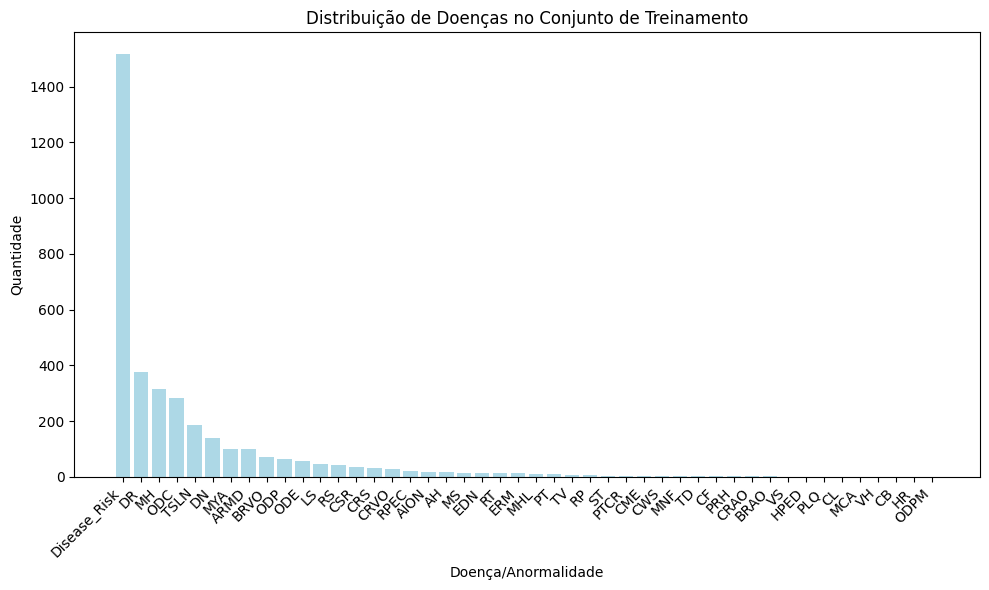

In [55]:
#Verificando a quantidade de cada label (conjunto de treino)
disease_counts = train_labels.iloc[:, 1:].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(disease_counts.index, disease_counts.values, color='lightblue')

plt.title('Distribuição de Doenças no Conjunto de Treinamento')
plt.xlabel('Doença/Anormalidade')
plt.ylabel('Quantidade')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### Abaixo, desenvolvemos uma função para carregar as imagens, associá-las às labels pelo ID (documentado no dataset como chave para cada imagem), remover as imagens que a label não é o alvo, e converter as imagens em formato JPG para arrays NumPy. O tamanho da imagem foi deixado opcional, podendo ser ajustado conforme necessário. Inicialmente, consideramos trabalhar com as dimensões originais da maioria das imagens, que são 2144x1424, uma vez que isso poderia preservar mais detalhes, algo importante em casos sensíveis, como os relacionados à saúde. No entanto, decidimos padronizar o tamanho das imagens para 224x224 para garantir o teste com todas as arquiteturas, independentemente dos artigos base. 

##### Há duas razões principais para essa decisão:

##### 1. **Nível de Detalhe**: Embora imagens maiores possam conservar mais detalhes, a relevância desses detalhes depende do contexto. Como conversado em sala de aula, normalmente seria necessário consultar um especialista para determinar até que ponto esse nível de detalhe realmente faz diferença nos diagnósticos. Baseado nos artigos utilizados como guia neste trabalho, optamos por seguir o padrão de img_size menor, como 224x224, que é amplamente adotado em arquiteturas de deep learning, mesmo em estudos de imagens médicas e nos nossos artigos base.

##### 2. **Limitações de Recursos**: Testamos tamanhos de imagem maiores, como 512x512, e até utilizamos as dimensões originais. No entanto, esses experimentos revelaram um consumo de RAM extremamente elevado. No Google Colab, por exemplo, houve estouro de memória, e mesmo em máquinas com 32 GB de RAM (locais), o processamento foi interrompido. Diante dessa limitação de recursos sem custo adicional, optamos por manter o tamanho de 224x224, que também é utilizado em alguns modelos propostos pelos artigos base.


### **Atenção no Texto e Bloco de Código Abaixo:**

#### Aqui temos duas opções diferentes de tratamento para o dataset, que irão alterar **todos** os resultados a partir deste ponto. A razão para isso é que, nosso objetivo principal é identificar se a retina tem ou não alguma doença ou anormalidade, como desafio nós estamos tentando identificar a(s) doença(s) ou anormalidade(s) que podem ser identificadas pela retina. (Chegamos a tratar disso em sala)

In [56]:
# Descomente/Comente abaixo para os exemplos com a previsão das 5 doenças/anormalidades com mais amostras
# label_names = train_labels.loc[:, train_labels.columns.isin(["DR", "MH", "ODC", "TSLN", "DN"])].columns.values


# Descomente/Comente abaixo para os exemplos com previsão apenas da presença de doença ou anormalidade(Diasease_Risk)
label_names = train_labels.loc[:, train_labels.columns.isin(["Disease_Risk"])].columns.values


In [57]:
def load_images_with_labels(images_dir, labels_df, img_size=(224, 224)):
    images = []
    labels = []

    for index, row in labels_df.iterrows():
        img_name = str(row['ID']) + '.png'

        # Se houver mais de uma coluna em label_names, ou seja, o objetivo é identificar as doenças/anormalidades
        if len(label_names) > 1:
            # labels relevantes
            label = row[label_names]

            # Verifica se existe algum valor positivo nas colunas que não estão em label_names (doenças/anormalidades mais frequentes)
            non_label_columns = [col for col in labels_df.columns if col not in label_names and col != "Disease_Risk" and col != "ID"]

            # Se algum valor em colunas fora de label_names for true, pulamos a imagem
            if row[non_label_columns].sum() > 0:
                print(f'Imagem {img_name} removida por ter valor positivo em colunas não permitidas.')
                continue

        else:
            #Se não houver mais de uma coluna, ou seja, o alvo é identificar se há ou não doença/anormalidade
            label = row[label_names]

        # Caminho da imagem
        img_path = os.path.join(images_dir, img_name)
        
        # Verifica se a imagem existe, abre, redimensiona, normaliza e associa a label
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img = img.resize(img_size)  # Redimensiona para 224x224 (Ou o tamanho que você quiser ao chamar a função, não recomendado mexer no padrão, pois não testamos com outros)

            img_array = np.array(img) / 255.0  # Normaliza entre 0 e 1, melhorando a compatibilidade com ReLu, que é amplamente utilizado nos artigos base

            # Adicionar a imagem e as labels aos arrays finais
            images.append(img_array)
            labels.append(label)
        else:
            print(f'Imagem {img_name} não encontrada no diretório {images_dir}') #Apenas para identificar que o Dataset não foi corretamente carregado

    return np.array(images), np.array(labels)

# Carregar os dados
train_images_dir = 'retinas/Training_Set/Training_Set/Training'
test_images_dir = 'retinas/Test_Set/Test_Set/Test'
validation_images_dir = 'retinas/Evaluation_Set/Evaluation_Set/Validation'

X_train, y_train = load_images_with_labels(train_images_dir, train_labels)
X_test, y_test = load_images_with_labels(test_images_dir, test_labels)
X_val, y_val = load_images_with_labels(validation_images_dir, validation_labels)

# Exibir as formas dos conjuntos filtrados
print(f'Train: {X_train.shape}, Labels: {y_train.shape}')
print(f'Test: {X_test.shape}, Labels: {y_test.shape}')
print(f'Validation: {X_val.shape}, Labels: {y_val.shape}')



Train: (1920, 224, 224, 3), Labels: (1920, 1)
Test: (640, 224, 224, 3), Labels: (640, 1)
Validation: (640, 224, 224, 3), Labels: (640, 1)


##### **OBS 1:** É importante ressaltar que estamos mantendo as imagens em RGB neste momento (224x224x3). No entanto, caso seja necessário utilizar escalas de cinza (greyscale) ou outra técnica que altere esse formato, faremos a conversão no bloco específico da arquitetura proposta. Estamos mantendo o formato RGB agora porque ele é o formato original das imagens e também é utilizado em algumas das arquiteturas testadas neste trabalho. 

#### **OBS 2:**  Na função acima (load_images_with_labels), aplicamos um filtro com a finalidade de selecionar os dados alvo das nossas labels, focado exclusivamente na identificação de doenças/anormalidades. Limitamos as labels para incluir apenas as de interesse, e filtramos também as imagens que consideramos relevantes. Tomamos o cuidado de não remover imagens que poderiam representar casos normais, e isso melhorou significativamente o desempenho dos nossos modelos. Dependendo da quantidade de dados nas labels escolhidas, os modelos enfrentavam imensa dificuldade para generalizar e, em alguns casos, apresentavam overfitting extremo, chegando a ter 99% de acurácia no treino, mas menos de 20% de acerto na validação. Com a abordagem atual, conseguimos uma visão mais realista da precisão dos modelos, mesmo que a acurácia final possa não ser tão alta.


array([0], dtype=int64)

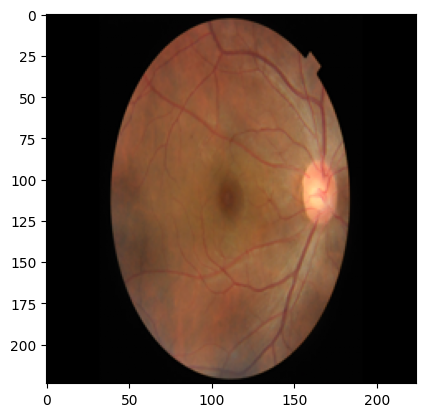

In [58]:
#Verificando uma Imagem e suas labels
i = 700
plt.imshow(X_train[i])
y_train[i]

array([1], dtype=int64)

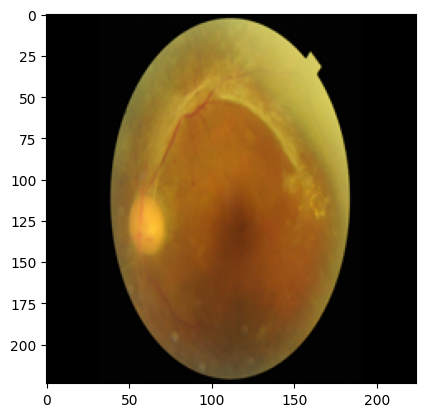

In [59]:
#Embaralhamento, evitar que padrões especificos sejam aprendidos
X_train, y_train = shuffle(X_train, y_train)

i = 700
plt.imshow(X_train[i])
y_train[i]

## Primeira Arquitetura Testada → Deep learning for identifying and classifying retinal diseases

### Ref: https://sci-hub.se/10.1109/ICCIS49240.2020.9257674

### **Resumo**

#### O autor introduz o problema central do trabalho (mencionado anteriormente), focando nas seguintes doenças: CNV, DRUSEN, AMD e DME.

##### **CNV (Neovascularização Coroidal):** CNV é uma condição caracterizada pelo crescimento anormal de vasos sanguíneos abaixo da retina, na camada coroidal. Isso pode levar à perda de visão central. É frequentemente associada à degeneração macular relacionada à idade (AMD) em sua forma úmida, embora possa ocorrer em outras doenças oculares.

##### **Drusen:** Drusen são pequenos depósitos amarelos de lipídios e proteínas que se formam sob a retina. Eles podem ser inofensivos em pequenos números (drusen duros), mas drusen moles, que são maiores e mais numerosos, podem ser um indicador de risco para o desenvolvimento da degeneração macular relacionada à idade (AMD).

##### **AMD (Degeneração Macular Relacionada à Idade):** AMD é uma doença ocular que afeta a mácula, a parte central da retina responsável pela visão nítida e detalhada. Existem duas formas principais: a seca (mais comum e progressiva) e a úmida (menos comum, mas mais rápida e grave). AMD pode levar à perda da visão central, dificultando atividades como ler e reconhecer rostos.

##### **DME (Edema Macular Diabético):** DME é uma complicação do diabetes que ocorre quando os vasos sanguíneos da retina vazam fluido, causando inchaço na mácula. Isso pode resultar em visão embaçada ou distorcida. DME é uma das principais causas de perda de visão em pessoas com retinopatia diabética.

#### Essas quatro doenças são o foco central deste artigo, pois, segundo o autor, são condições que, se descobertas precocemente, podem ser tratadas. No entanto, em casos avançados, podem não ter tratamento, levando à perda parcial ou total da visão. O artigo propõe uma CNN (Convolutional Neural Network), que inicialmente não utiliza transfer learning. Um ponto interessante do artigo é que ele propõe várias arquiteturas, principalmente usando transfer learning. No decorrer do artigo, a primeira arquitetura é apresentada e, em minha opinião, é bastante robusta para evitar overfitting e capturar detalhes. A primeira proposta é complementada por outras e pode ser resumida da seguinte forma:

##### → Camada Convolucional, 32 filtros, entrada de 224x224x3, kernel_size 3x3, strides 1x1, ativação ReLU
##### → Camada de Max Pooling, pool_size 4x4
##### → Camada de Dropout, 10%
##### → Camada Convolucional, 512 filtros, kernel_size 3x3, strides 1x1, ativação ReLU
##### → Camada de Max Pooling, pool_size 3x3
##### → Camada Convolucional, 32 filtros, kernel_size 3x3, strides 1x1, ativação ReLU
##### → Camada de Max Pooling, pool_size 3x3
##### → Camada de BatchNormalization, para distribuir as ativações de forma mais consistente
##### → Camada Flatten, para converter o mapa de características 3D em um vetor 1D
##### → Camada Densa com 128 neurônios, totalmente conectada
##### → Camada Densa de saída com 4 neurônios, ativação Softmax

##### → Modelo Sequencial, batch size 80, 15 épocas, early stopping com paciência de 10
##### → Otimizador Adam, taxa de aprendizado 0.001

#### Em seguida, o autor introduz o transfer learning, apresentando dois modelos pré-treinados: Inception V3 e VGG-16, além de uma versão modificada do VGG-16. Ele também menciona o pré-processamento realizado com o dataset utilizado em seus testes, e por fim, exibe os resultados de cada abordagem, incluindo transfer learning. Os melhores resultados foram obtidos com a arquitetura que abordamos acima e com o uso de transfer learning utilizando o Inception V3, ambos alcançando mais de 98% de acurácia. O pior resultado veio da abordagem com transfer learning utilizando o VGG-16 não modificado, cuja acurácia ficou entre 50% e 53%, ou seja, pouco melhor do que uma escolha aleatória.

##### **OBS:** A arquitetura detalhada e destacada acima pareceu bem simples e funcional para o nosso problema. Além disso, a ilustração da arquitetura CNN foi bastante interessante, e o fato de o tema ser semelhante ao nosso chamou nossa atenção. Decidimos tentar, visto que o artigo apresentou bons resultados e uma boa explicação sobre como executar. Fizemos nossas adaptações, já que o problema tratado no artigo é uma CNN multiclass, enquanto o nosso é multilabel (as alterações foram destacadas no código). Por fim, decidimos não adotar transfer learning nesta solução, mesmo que no artigo cite essa técnica. Em nossas discussões, consideramos a possibilidade de utilizar transfer learning em uma tentativa de arquitetura futura, pois no artigo o melhor exemplo com transfer learnig teve um desempenho similar ao da CNN proposta, e também por questões de perfomance e variedade, lemos alguns artigos que nem são citados neste documento, e é relativamente comum tentar resolver problemas similares a esse usando transfer learning, então nossa ideia é pelo menos propor uma CNN com bons resultados.

In [60]:
# Modelo Sequencial
model = models.Sequential()

# Primeira camada convolucional (32 filtros, kernel 3x3, stride 1)
# Poderia ter destacada a camada de entrada da conv, mas dá na mesma e decidi aplicar este conhecimento de sala de aula
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4)))  # Max pooling 4x4
model.add(layers.Dropout(0.1))  # Dropout de 10% para evitar overfitting

# Segunda camada convolucional (512 filtros, kernel 3x3, stride 1)
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3)))  # Max pooling 3x3

# Terceira camada convolucional (32 filtros, kernel 3x3, stride 1)
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3)))  # Max pooling 3x3
model.add(layers.BatchNormalization())  # Normalizar as ativações antes de passar para as camadas subsequentes

# Converter Tensores 3D em Vetores 1D (Prepara a saída convolucional para o uso em camadas densas)
model.add(layers.Flatten()) 

# Camada densa fully conected
model.add(layers.Dense(units=128, activation='relu'))

model.add(layers.Dense(units=len(label_names), activation='sigmoid'))  # Multi-label, então sigmoid para prever várias classes independentes

adam = optimizers.Adam(learning_rate=0.001)

# Compilar o modelo, adam como sugerido no artigo
model.compile(optimizer=adam,
              loss='binary_crossentropy',  # Binary crossentropy para multi-label classification
              metrics=['accuracy'])

model.summary()

c:\Users\mieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 53, 53, 512)    │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 15, 15, 32)     │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 399,137 (1.52 MB)

 Trainable params: 399,073 (1.52 MB)

 Non-trainable params: 64 (256.00 B)

In [61]:
# Callback de monitoramento com Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Treinamento do modelo
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=80,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 945ms/step - accuracy: 0.7694 - loss: 0.5381 - val_accuracy: 0.4437 - val_loss: 0.7127
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 917ms/step - accuracy: 0.8036 - loss: 0.4232 - val_accuracy: 0.7750 - val_loss: 0.5218
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 934ms/step - accuracy: 0.8407 - loss: 0.3756 - val_accuracy: 0.3438 - val_loss: 0.7795
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 935ms/step - accuracy: 0.8143 - loss: 0.4245 - val_accuracy: 0.7891 - val_loss: 0.4332
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 920ms/step - accuracy: 0.8490 - loss: 0.3639 - val_accuracy: 0.7797 - val_loss: 0.5171
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 917ms/step - accuracy: 0.8314 - loss: 0.3869 - val_accuracy: 0.8250 - val_loss: 0.4072
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 925ms/step - accuracy: 0.8372 - loss: 0.3763 - val_accuracy: 0.7906 - val_loss: 0.4998
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 927ms/step - accuracy: 0.8546 - loss: 0.3406 - val_accu

### Resultados

#### **Doenças/Anormalidades:**

#### Passando brevemente pelos resultados, inicialmente plotamos um gráfico de aprendizado. No gráfico de perda, observamos uma rápida diminuição nas primeiras épocas, o que indica que o modelo está aprendendo bem, tanto no treino quanto na validação.

#### No gráfico de acurácia, vemos que o modelo está aprendendo rapidamente nas primeiras épocas, mas a acurácia de validação apesar de aumentar, se mantém instável o que me faz suspeitar da generalização do modelo, e isso foi um problema bem frequente durante este trabalho nesta modalidade de doenças/anormalidades, acredito que pela baixa quantidade de amostras de cada doença/anormalidade alvo e também pela diferença entre a quantidade de amostras de cada doença/anormalidade alvo (Ao longo do documento, tentamos resolver isso). 


#### **Identificar se tem ou não Doença/Anormalidade:**

#### Segundo o gráfico de perda, sugere que o modelo aprende bem, mas na validação está com dificuldades para generalizar ou muito sensível a pequenas mudanças.

#### A acurácia mostra que apesar do modelo está aprendendo bem, por isso a validação sugere um possível overfitting pelas quedas repentinas, parece estar tendo dificuldades para generalizar.


#### Mais a frente, eu ploto matrizes de confusão para cada label e verifico a quantidade de acertos do modelo, e sinceramente, esperávamos resultados melhores, especialmente na previsão de múltiplas labels. Para o próximo experimento, a intenção é focar em um artigo mais específico para a classificação multilabel, já que neste exemplo tentamos obter resultados de uma CNN multiclass com uma CNN multilabel, e a imagem de entrada não seguia o mesmo padrão da nossa, então talvez melhores maneiras de tratar a imagem possa ajudar.

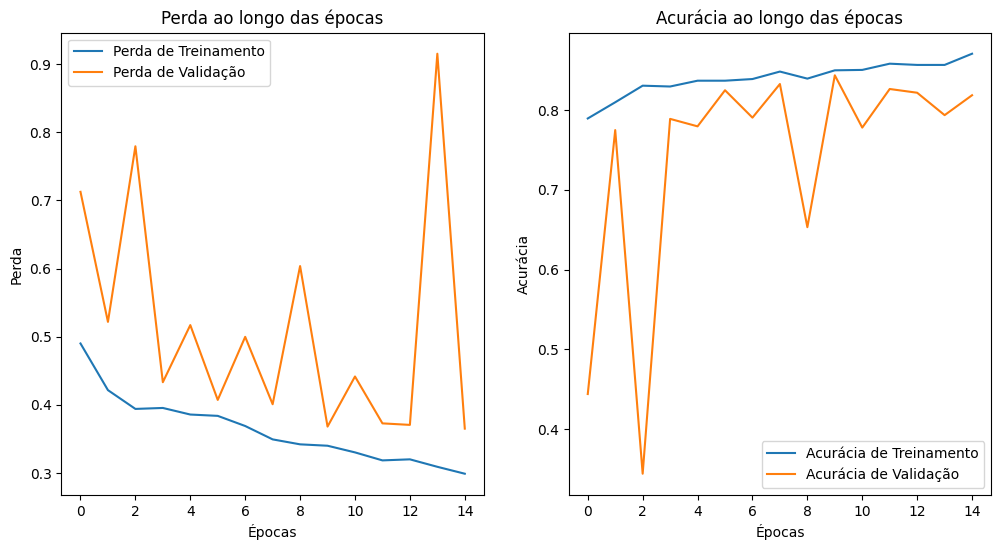

In [62]:
#Verificando o desempenho do modelo
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


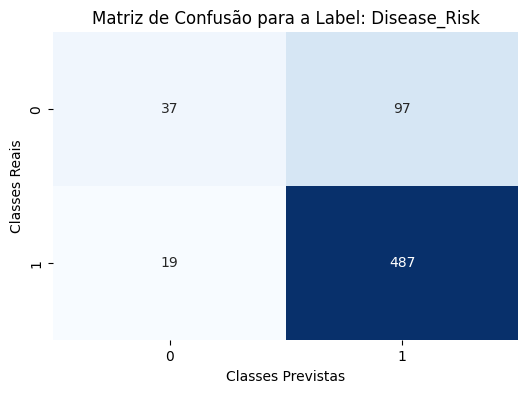

In [63]:
#Esse threshold será global, já os demais podem mudar de acordo com o tratamento dos dados.
threshold = 0.5
y_true_val = y_val
y_pred_val = model.predict(X_val)
y_pred_labels = (y_pred_val > threshold).astype(int)

#Matrix de confusão de cada label
for i, label in enumerate(label_names):
    conf_matrix = confusion_matrix(y_true_val[:, i], y_pred_labels[:, i], labels=[0, 1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusão para a Label: {label}')
    plt.xlabel('Classes Previstas')
    plt.ylabel('Classes Reais')
    plt.show()

Número de previsões corretas: 524
Número de previsões incorretas: 116


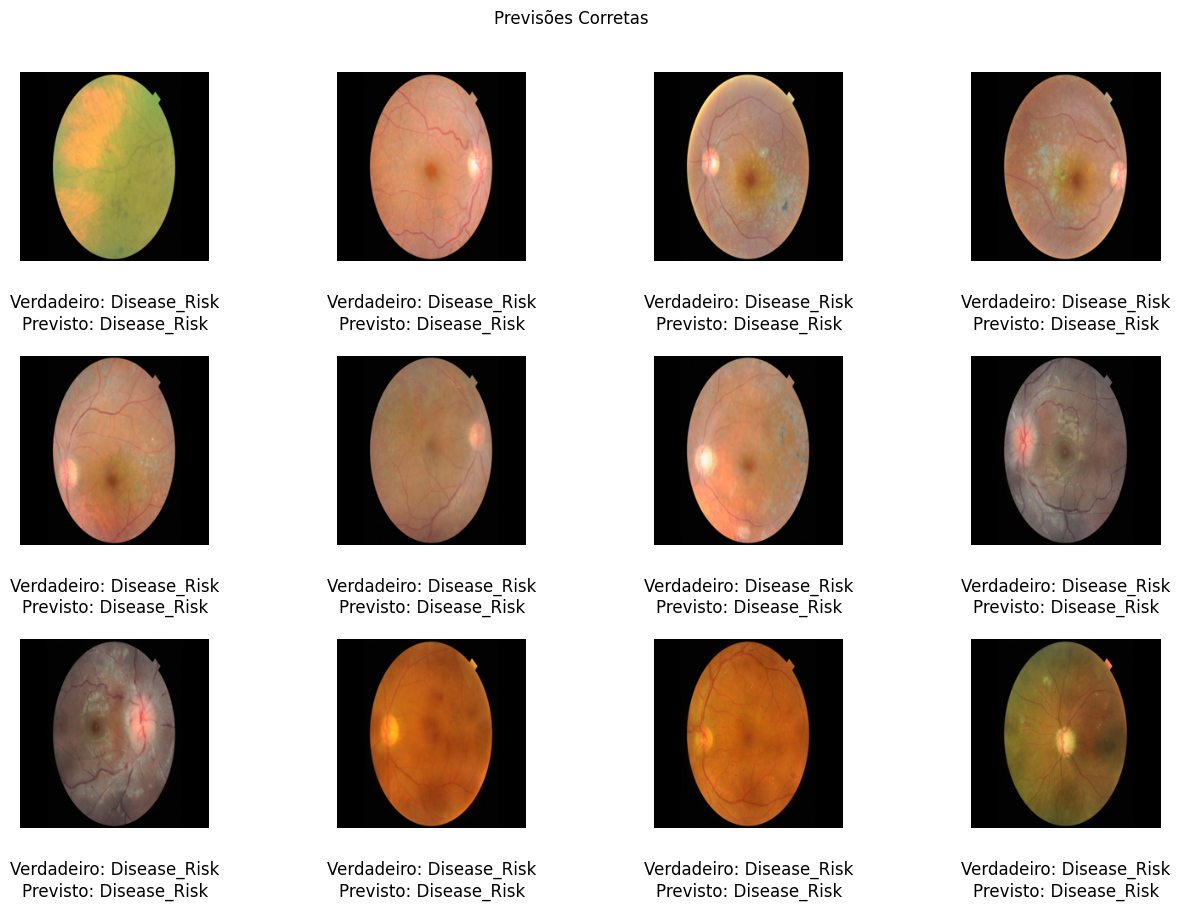

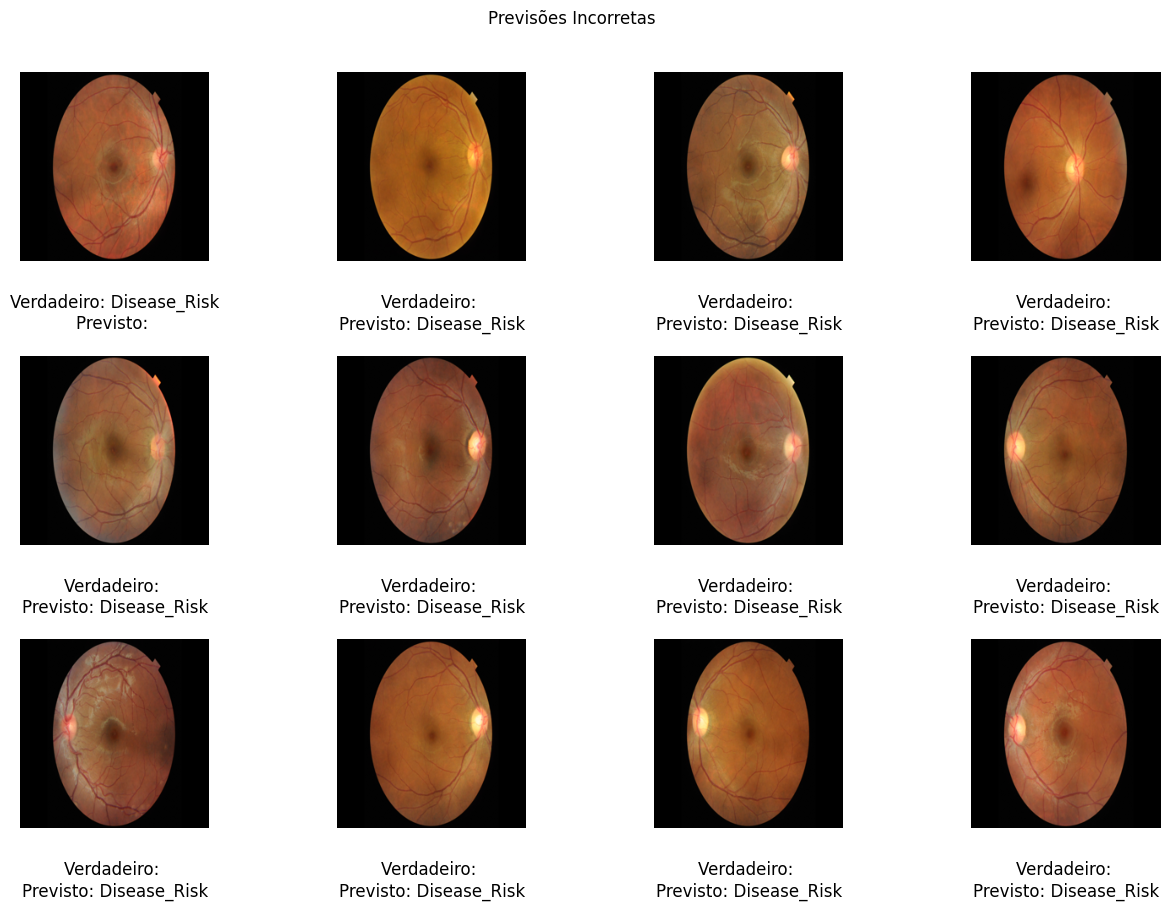

In [64]:
correct_indices = np.where(np.all(y_pred_labels == y_true_val, axis=1))[0]
incorrect_indices = np.where(np.any(y_pred_labels != y_true_val, axis=1))[0]

print(f"Número de previsões corretas: {len(correct_indices)}")
print(f"Número de previsões incorretas: {len(incorrect_indices)}")

# Função para exibir imagens (Pode alterar a quantidade de previsões mostradas, vamos limitar a 12 para não ficar extenso)
def plot_images_in_batches(indices, title, batch_size, images_per_row):
    num_images = len(indices)
    batch_size = min(batch_size, num_images) 

    batch_indices = indices[:batch_size]
    rows = (len(batch_indices) // images_per_row) + (len(batch_indices) % images_per_row > 0)

    plt.figure(figsize=(15, rows * 3))
    for i, idx in enumerate(batch_indices):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(X_val[idx].reshape((224,224,3)))  # Exibe a imagem correspondente

        # Rótulos verdadeiros e previstos para a imagem atual
        true_labels = [label_names[j] for j in range(len(label_names)) if y_true_val[idx, j] == 1]
        predicted_labels = [label_names[j] for j in range(len(label_names)) if y_pred_labels[idx, j] == 1]

        # Exibe os rótulos verdadeiros e previstos
        plt.title(f"Verdadeiro: {', '.join(true_labels)}\nPrevisto: {', '.join(predicted_labels)}", y=-0.4)
        plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)  # Ajusta o espaço entre as imagens
    plt.suptitle(title, y=1.02)
    plt.show()

# Exibe previsões corretas e incorretas
plot_images_in_batches(correct_indices, "Previsões Corretas", batch_size=12, images_per_row=4)
plot_images_in_batches(incorrect_indices, "Previsões Incorretas", batch_size=12, images_per_row=4)

## Segunda Arquitetura Testada → A Multi-Label Deep Learning Model with Interpretable Grad-CAM for Diabetic Retinopathy Classification


### Ref: https://sci-hub.se/10.1109/EMBC44109.2020.9175884

### **Resumo** -> Pendente (até amanhã)

#### **OBS:** Este foi o artigo mais próximo do nosso problema. Escolhemos com altas expectativas, mesmo sabendo da complexidade de executar essa arquitetura sem muitas instruções sobre os hiperparâmetros usados no modelo do artigo. Independentemente do resultado da arquitetura, este artigo nos apresentou 4 técnicas interessantes: CLAHE, Data Augmentation, Grad-CAM e Transfer Learning em duas etapas. CLAHE e Data Augmentation serão utilizados não só aqui, mas em outros problemas. Já o Transfer Learning em duas etapas e o Grad-CAM nos trouxeram alguns desafios. O Transfer Learning é normalmente mais complexo e demorado, além de não ter apresentado resultados satisfatórios neste caso. Quanto ao Grad-CAM, é uma técnica que basicamente só poderia ser validada por um especialista na área. Nós o implementamos para testes, mas, no geral, estava presente apenas para incluir mais código, então o removemos após discussões em sala de aula.

In [65]:
# Definição do ClAHE, e explicação de onde tiramos os parametros
def apply_clahe_to_green_channel(X):
    processed_images = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Com base em alguns testes e pesquisas de uso na área da saúde

    for img_array in X:
        # Priorizando o canal verde, pois na fonte do artigo é destacado o poder que o canal verde tem em extrair caractéristicas importantes nestes problemas
        green_channel = img_array[:, :, 1]
        green_clahe = clahe.apply((green_channel * 255).astype(np.uint8))
        
        # Substituindo o canal verde da imagem original pelo canal processado
        img_clahe = img_array.copy()
        img_clahe[:, :, 1] = green_clahe / 255.0  # Normalizando novamente para a escala 0-1 (Se não normalizar novamente a imagem vai ficar completamente esverdeada)

        processed_images.append(img_clahe)

    return np.array(processed_images)

# Aplicando CLAHE nas imagens do conjunto de treino, teste e validação (Vão ser os que vamos usar neste artigo)
X_train_clahe = apply_clahe_to_green_channel(X_train)
X_test_clahe = apply_clahe_to_green_channel(X_test)
X_val_clahe = apply_clahe_to_green_channel(X_val)

# Verificando se a saída está nos conformes
print(f'Train: {X_train_clahe.shape}')
print(f'Test: {X_test_clahe.shape}')
print(f'Validation: {X_val_clahe.shape}')

Train: (1920, 224, 224, 3)
Test: (640, 224, 224, 3)
Validation: (640, 224, 224, 3)


array([1], dtype=int64)

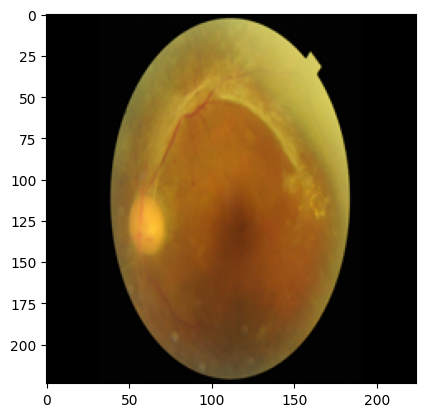

In [66]:
#Testando a imagem no conjunto normal
i = 700
plt.imshow(X_train[i])
y_train[i]

array([1], dtype=int64)

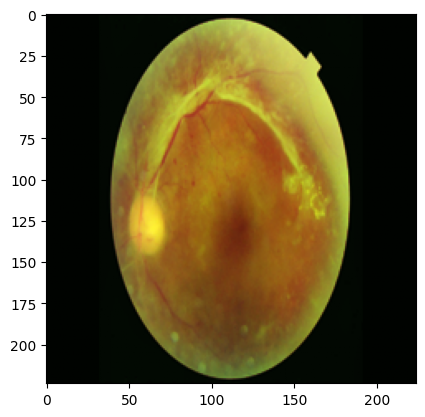

In [67]:
# Plotando a mesma imagem de teste para verificar se realmente teve diferenças(também fiz uma comparação com a imagem usada no artigo, me agradou desta maneira que ficou, além dos testes) 
i = 700
plt.imshow(X_train_clahe[i])
y_train[i]

In [68]:
# Carregando o modelo base (ResNet50, pegando os pesos imagenet e ignorando as camadas totalmente conectadas)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelando o modelo base durante a primeira fase de treinamento como citado no artigo
base_model.trainable = False

# Três camadas convolucionais mostradas no artigo(filtros, kernel_size e padding setados atráves testes)
# Fazendo uma regressão com os filtros, e uma redução com o kernel size
# Nesta arquitetura estamos usando uma especie de shorthand para kernel_size e filters (Variar e colocar a prova essas técnicas)
x = base_model.output
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)


# Global average pooling antes da camada de saída para resumir tudo em um vetor de características
x = layers.GlobalAveragePooling2D()(x)

# Sigmoid para multi-label classification
output = layers.Dense(len(label_names), activation='sigmoid')(x)

# Criar o modelo definitivo (Mesma entrada ResNet50 e a saída tem as 3 camadas convolucionais que adicionei)
model = models.Model(inputs=base_model.input, outputs=output)

# Data augmentation conforme o artigo
datagen = ImageDataGenerator(
    rotation_range=45,       
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    horizontal_flip=True,    
    vertical_flip=True,      
    fill_mode='nearest'      
)

# Gerador para o conjunto de treino, reduzindo um pouco o batch_size anterior com base em testes e padrão.
train_generator = datagen.flow(X_train_clahe, y_train, batch_size=64)

# Gerador para validação
val_datagen = ImageDataGenerator()  # Sem augmentação, manter validação e teste autenticos(como deveriam ser)
val_generator = val_datagen.flow(X_val_clahe, y_val, batch_size=64)

# Primeira fase do treinamento, binary_crossentropy para multi-label, primeira com learning_rate 0.01 conforme artigo
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

#Verificar a arquitetura com resnet-50
model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 48,362,369 (184.49 MB)

 Trainable params: 24,774,657 (94.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [69]:
# Adotei o early_stopping vindo lá do primeiro artigo, neste ele não cita, mas acho interessante ter um freio caso não tenhamos resultados melhores.
# Ainda mais quando esse treino é o mais demorado deste trabalho
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento inicial com a base congelada conforme o artigo, com 10 épocas, pois é muito demorado mesmo
history_1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Segunda fase do treinamento descongelando a base conforme o artigo
base_model.trainable = True

# Recompilando o modelo com uma taxa de aprendizado ainda menor conforme o artigo
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Treinando todo o modelo, com 10 épocas, pois além de demorado foi o sugerido no artigo anterior
history_2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\mieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5548 - loss: 1026.9374 - val_accuracy: 0.2094 - val_loss: 0.7559
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7253 - loss: 0.6251 - val_accuracy: 0.7906 - val_loss: 0.5165
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7873 - loss: 0.5282 - val_accuracy: 0.7906 - val_loss: 0.5265
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7764 - loss: 0.5607 - val_accuracy: 0.7906 - val_loss: 0.5849
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7989 - loss: 0.5430 - val_accuracy: 0.7906 - val_loss: 0.5147
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7753 - loss: 0.5361 - val_accuracy: 0.7906 - val_loss: 0.5132
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7802 - loss: 0.5268 - val_accuracy: 0.7906 - val_loss: 0.5132
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7957 - loss: 0.5063 - val_accuracy: 0.7906 - val_loss: 0.5131


### Resultados

#### **Doenças/Anormalidades:**

#### Tanto na perda quanto na acurácia, observamos um grande overfitting. Na perda, o gráfico indica que o modelo não está conseguindo aprender de forma consistente, enquanto na acurácia fica claro que ele não está conseguindo generalizar, enfrentando muita dificuldade para aprender. Isso se agrava ao ponto de não conseguir mais generalizar durante o segundo treinamento. E isso foi uma regra nesse modelo, mesmo que alterássemos as épocas para 100 ou tentássemos mudar alguns parâmetros. (Por isso definimos 10 épocas, pois o resultado é basicamente o mesmo, mas a demora deste modelo para ser treinado é superior à dos demais).

#### **Identificar se tem ou não Doença/Anormalidade:**

#### A perda rapidamente cai para quase 0, semelhante à validação, o que sugere que na primeira fase o modelo pode estar superajustado aos dados. Na segunda fase, a validação parece estar enfrentando dificuldades de generalização, mas o treino ainda se mantém perto de 0. Podemos dizer que ocorreu um overfitting. Na acurácia da primeira fase, o gráfico mostra que o modelo aprendeu bem e de maneira mais consistente, confirmado pela curva de validação, que se mantém no mesmo nível de estabilidade. Porém, quando avançamos para a segunda fase, há uma certa instabilidade, o que pode indicar dificuldade em generalizar ou grande sensibilidade a pequenos ajustes.

#### Ao escolhermos tentar este modelo, imaginávamos que, pela complexidade, tempo de execução e o problema ser muito similar ao nosso, os resultados seriam melhores. Tentamos extrair um bom desempenho e evitar o overfitting neste modelo sem alterar a arquitetura proposta pelo artigo, mas nossos resultados sempre apontavam para, ao menos, um possível overfitting. Alterando o `batch_size`, épocas, quantidade de filtros e até removendo dados que poderiam estar prejudicando o modelo, não obtivemos resultados significativos. Claro que saímos de um overfitting extremo para algo mais plausível, melhorando de no máximo 40% de acurácia na identificação de qual doença/anormalidade para até 60% de acurácia. No entanto, nossa intenção era obter um resultado significativamente melhor, sem a possibilidade de overfitting. Assim como nos demais modelos, parece que a quantidade de dados por amostra influenciou bastante nesses overfittings, principalmente na incapacidade dos modelos de generalizarem corretamente.


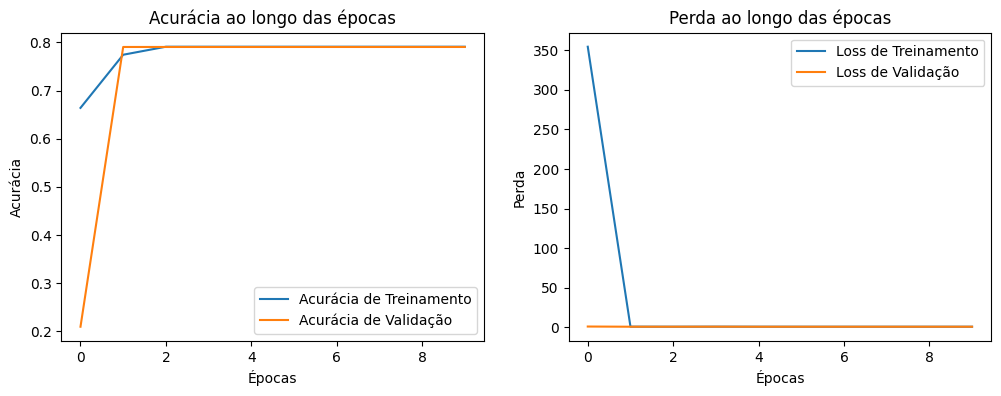

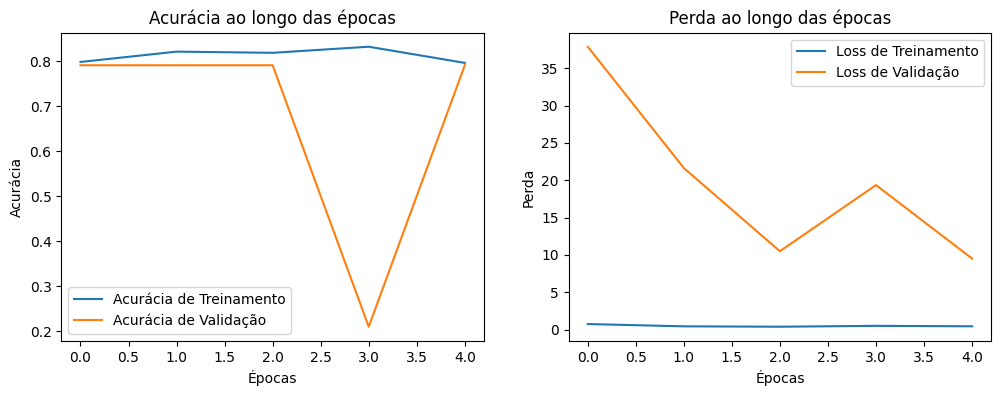

In [70]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.title('Perda ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Plotando gráfico de aprendizado para ambos os treinos
plot_learning_curves(history_1)
plot_learning_curves(history_2)


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 769ms/step


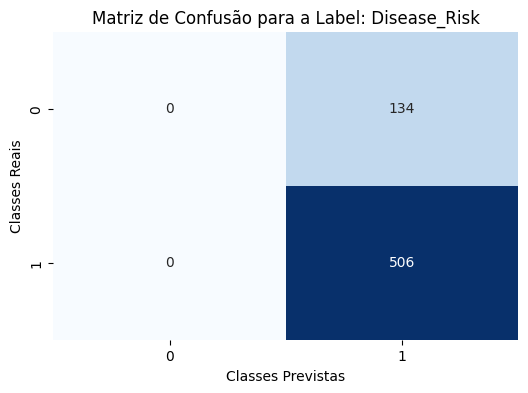

In [71]:
y_pred_val = model.predict(X_val_clahe)
y_pred_labels = (y_pred_val > threshold).astype(int)

#Matrix de confusão de cada label
for i, label in enumerate(label_names):
    conf_matrix = confusion_matrix(y_true_val[:, i], y_pred_labels[:, i], labels=[0, 1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusão para a Label: {label}')
    plt.xlabel('Classes Previstas')
    plt.ylabel('Classes Reais')
    plt.show()

Número de previsões corretas: 506
Número de previsões incorretas: 134


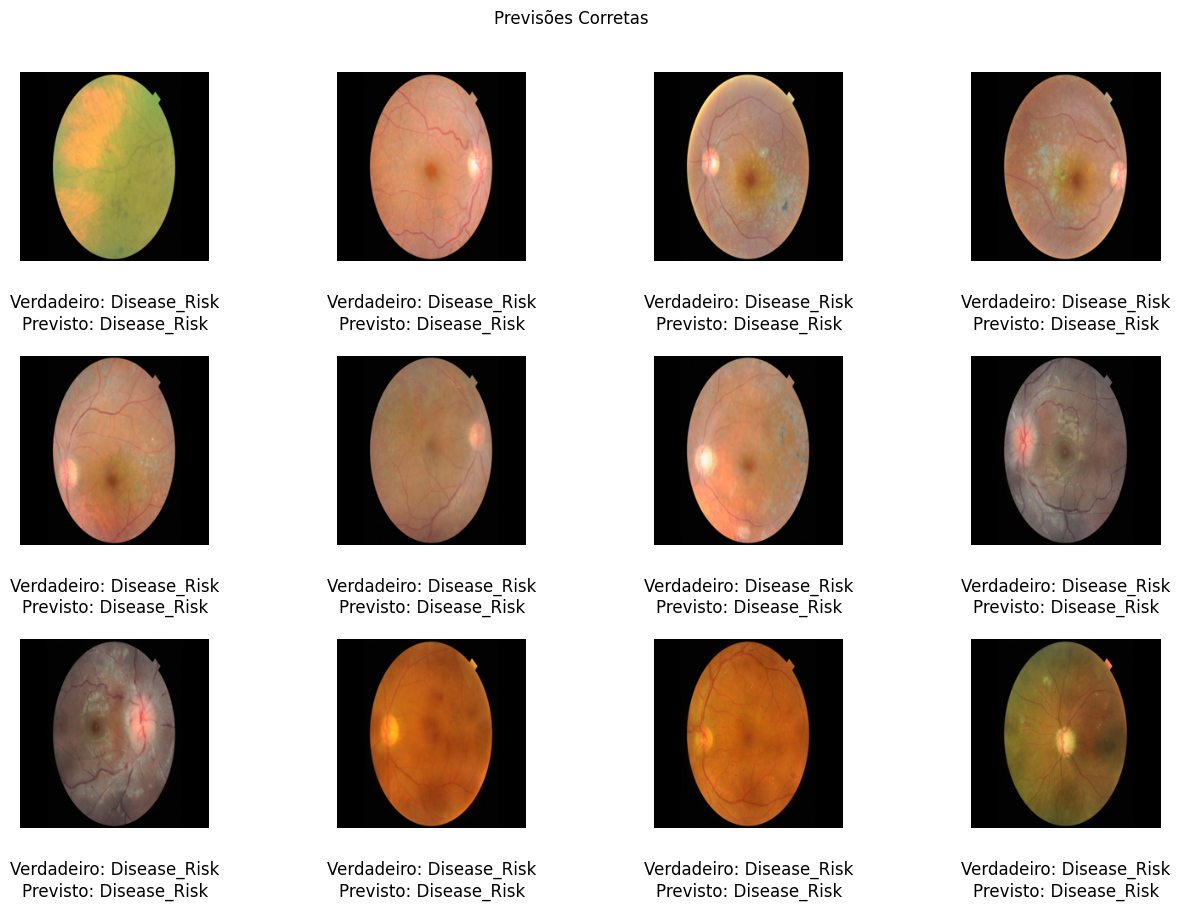

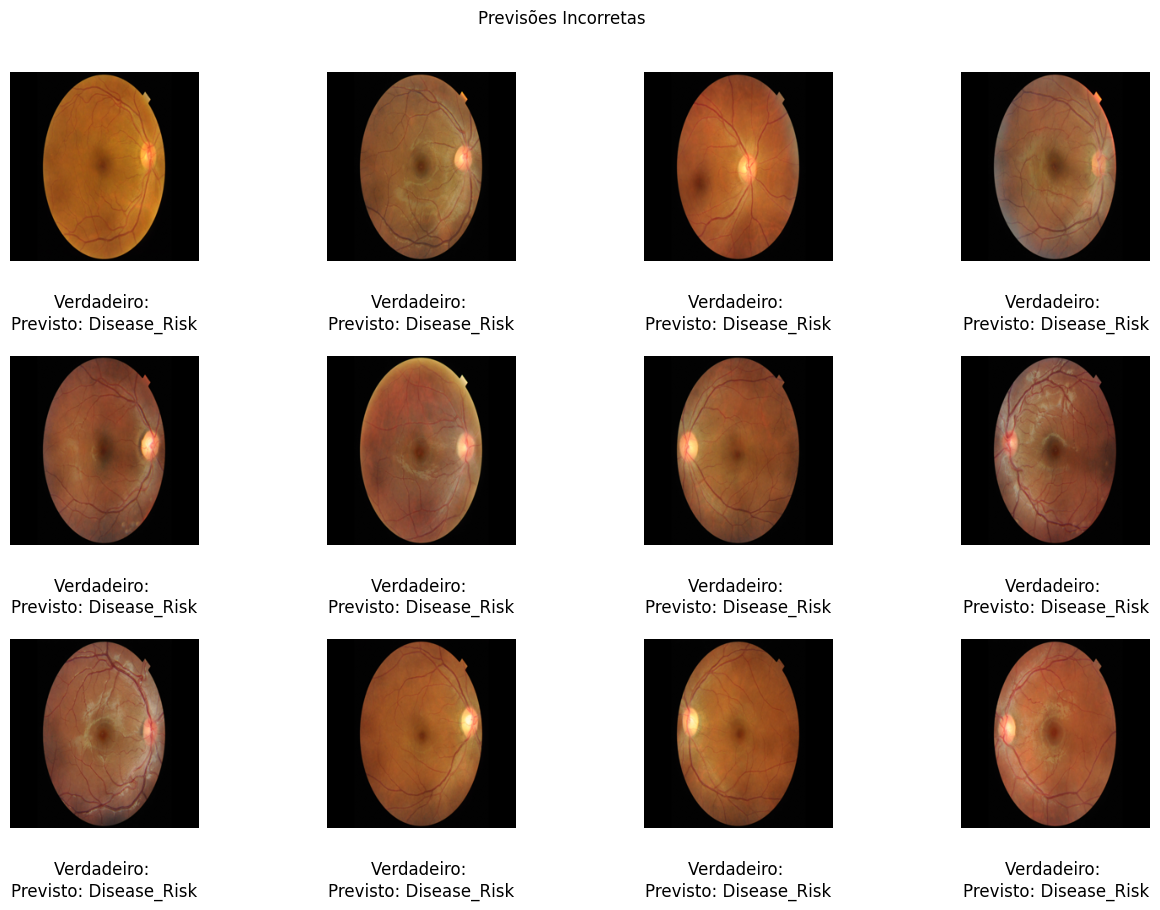

In [72]:
# Índices das previsões corretas e incorretas
correct_indices = np.where(np.all(y_pred_labels == y_true_val, axis=1))[0]
incorrect_indices = np.where(np.any(y_pred_labels != y_true_val, axis=1))[0]

print(f"Número de previsões corretas: {len(correct_indices)}")
print(f"Número de previsões incorretas: {len(incorrect_indices)}")

# Função auxiliar para exibir imagens
def plot_images_in_batches(indices, title, batch_size, images_per_row):
    num_images = len(indices)
    batch_size = min(batch_size, num_images) 

    batch_indices = indices[:batch_size]
    rows = (len(batch_indices) // images_per_row) + (len(batch_indices) % images_per_row > 0)

    plt.figure(figsize=(15, rows * 3))
    for i, idx in enumerate(batch_indices):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(X_val[idx].reshape((224,224,3)))

        # Rótulos verdadeiros e previstos para a imagem atual
        true_labels = [label_names[j] for j in range(len(label_names)) if y_true_val[idx, j] == 1]
        predicted_labels = [label_names[j] for j in range(len(label_names)) if y_pred_labels[idx, j] == 1]

        plt.title(f"Verdadeiro: {', '.join(true_labels)}\nPrevisto: {', '.join(predicted_labels)}", y=-0.4)
        plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)  # Ajusta o espaço entre as imagens
    plt.suptitle(title, y=1.02)
    plt.show()

# Exibir previsões corretas e incorretas
plot_images_in_batches(correct_indices, "Previsões Corretas", batch_size=12, images_per_row=4)
plot_images_in_batches(incorrect_indices, "Previsões Incorretas", batch_size=12, images_per_row=4)


## Meu modelo pessoal com base nos artigos

#### Considerando o modelo que obteve o melhor desempenho para identificar se tem doença/anormalidade e identificar qual a doença/anormalidade, não apenas pelo gráfico de aprendizagem, mas também pela performance e número de acertos, realizei algumas alterações para tentar melhorar a generalização. Entre as mudanças, utilizei técnicas como Data Augmentation, melhorias na detecção de detalhes com Crop e CLAHE, além de ajustes para tentar reduzir o problema da discrepância entre a quantidade de amostras para cada label, aplicando um balanceamento de pesos para dar mais destaque às labels com menor quantidade de amostras. Foram realizados vários testes, alternando entre essas técnicas, porém esta versão final, embora apresente acurácia e perda semelhantes, obteve uma quantidade maior de acertos.

In [73]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4))) 
model.add(layers.Dropout(0.1)) 

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3)))
model.add(layers.BatchNormalization()) 

model.add(layers.Flatten()) 

model.add(layers.Dense(units=128, activation='relu'))

model.add(layers.Dense(units=len(label_names), activation='sigmoid')) 

adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\mieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 53, 53, 512)    │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 15, 15, 32)     │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 399,137 (1.52 MB)

 Trainable params: 399,073 (1.52 MB)

 Non-trainable params: 64 (256.00 B)

In [74]:
# Tecnica sugerida durante discussão em sala, testada e trouxe melhores resultados.
def random_crop(image, crop_size=(200, 200)):
    original_size = tf.shape(image)
    cropped_image = tf.image.random_crop(image, size=[crop_size[0], crop_size[1], original_size[2]])
    
    return tf.image.resize(cropped_image, (224, 224))

# Data augmentation com Random Crop e CLAHE
datagen = ImageDataGenerator(
    rotation_range=45,       
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    horizontal_flip=True,    
    vertical_flip=True,      
    fill_mode='nearest',
    preprocessing_function=lambda img: random_crop(img, crop_size=(200, 200))
)

# Gerador para o conjunto de treino
train_generator = datagen.flow(X_train_clahe, y_train, batch_size=124)

# Gerador para validação (sem augmentação na validação)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val_clahe, y_val, batch_size=64)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


if len(label_names) > 1:
    # Calcular os pesos de classe caso tenhamos mais de uma coluna de rótulo
    N = len(train_labels)  # Número total de amostras
    frequencies = train_labels[label_names].sum().values  # Frequências de cada classe

    class_weights = {}
    for i, column in enumerate(label_names):
        n_i = frequencies[i]
        class_weights[column] = (1 / n_i) * (N / len(label_names))

    # Treinamento com pesos de classe
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        callbacks=[early_stopping],
        class_weight=class_weights
    )
else:
    # Treinamento sem pesos (apenas Disease_Risk)
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )



Epoch 1/100


c:\Users\mieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6794 - loss: 0.5848 - val_accuracy: 0.7906 - val_loss: 0.5054
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7897 - loss: 0.4818 - val_accuracy: 0.7906 - val_loss: 0.4970
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7884 - loss: 0.4658 - val_accuracy: 0.7906 - val_loss: 0.4775
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8020 - loss: 0.4480 - val_accuracy: 0.7891 - val_loss: 0.4931
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8010 - loss: 0.4503 - val_accuracy: 0.7906 - val_loss: 0.4833
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7872 - loss: 0.4580 - val_accuracy: 0.7891 - val_loss: 0.4631
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8016 - loss: 0.4352 - val_accuracy: 0.8078 - val_loss: 0.4791
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8116 - loss: 0.4166 - val_accuracy: 0.5266 - val_loss: 0.6

### Resultados

#### **Doenças/Anormalidades:**

#### No gráfico de perda, observamos uma diminuição consistente ao longo das épocas, o que sugere que o modelo está aprendendo bem a mapear os dados para cada label. No entanto, na validação, após uma diminuição inicial, houve instabilidade, o que indica uma possível dificuldade em se adaptar aos dados de validação, talvez devido à falta de generalização, pelos mesmos motivos citados anteriormente, ou seja, a quantidade limitada de amostras e a discrepância entre as quantidades de amostras entre as classes. No gráfico de acurácia, observamos um aumento consistente na acurácia do treinamento, sugerindo que o modelo está aprendendo a classificar corretamente. No entanto, a acurácia de validação está bastante irregular e instável, o que pode indicar que o modelo está superajustando aos dados de treinamento ou que ele é sensível a pequenas variações nos dados de validação.

#### **Identificar se tem ou não Doença/Anormalidade:**

#### O modelo parece estar sofrendo com overfitting, pois se adapta muito bem aos dados de treino, mas não consegue manter esse desempenho nos dados de validação, que assim como nos modelos anteriores apresenta instabilidade. Acredito que se tentar balancear a coluna disease_risk com positivos e negativos em quantidades proporcionais, a validação vá melhorar e possivelmente até o treino, porém teriamos que remover dados aleatoriamente (já que não temos um profissional na área para estebelecerum critério) e criar dados artificiais na área de saúde, principalmente para um dos cinco sentidos humanos, seria arriscado demais para ser aceitável em um modelo sério.

#### Com essa abordagem melhorada, conseguimos um leve aumento no desempenho do modelo que melhor se destacou nessa modalidade. Os acertos foram consideravelmente bons em comparação com os resultados anteriores. No entanto, o desempenho poderia ter sido muito melhor se tivéssemos mais dados disponíveis para cada doença/anormalidade, o que infelizmente não foi o caso, fizemos vários testes diferentes com diferentes abordagens e parâmetros, esse resultado abaixo pode se dizer que foi nossa melhor tentativa mesmo com possível overfitting.

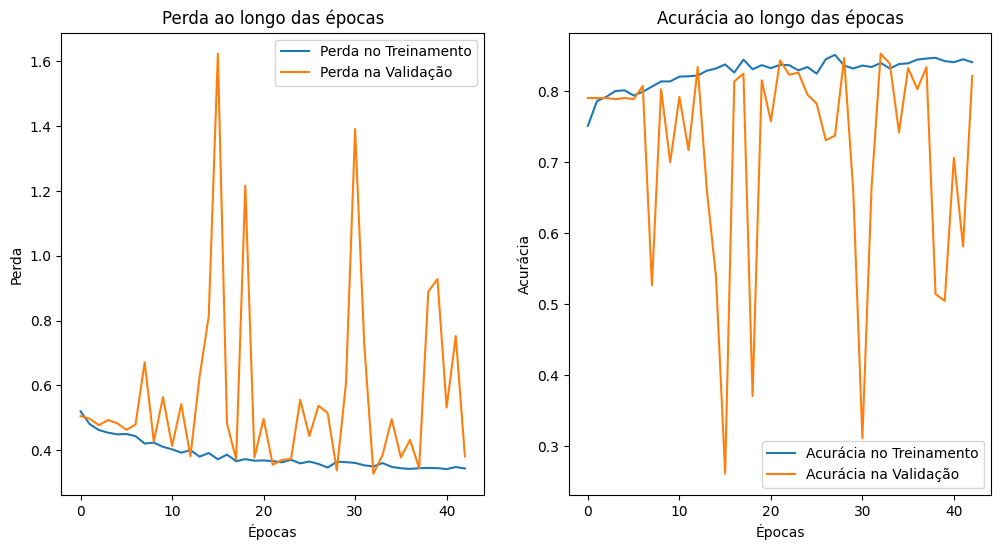

In [75]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Perda ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


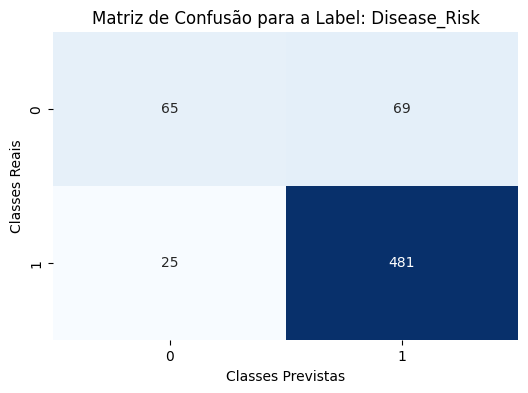

In [76]:
y_pred_val = model.predict(X_val_clahe)
y_pred_labels = (y_pred_val > threshold).astype(int)

#Matrix de confusão de cada label
for i, label in enumerate(label_names):
    conf_matrix = confusion_matrix(y_true_val[:, i], y_pred_labels[:, i], labels=[0, 1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusão para a Label: {label}')
    plt.xlabel('Classes Previstas')
    plt.ylabel('Classes Reais')
    plt.show()

Número de previsões corretas: 546
Número de previsões incorretas: 94


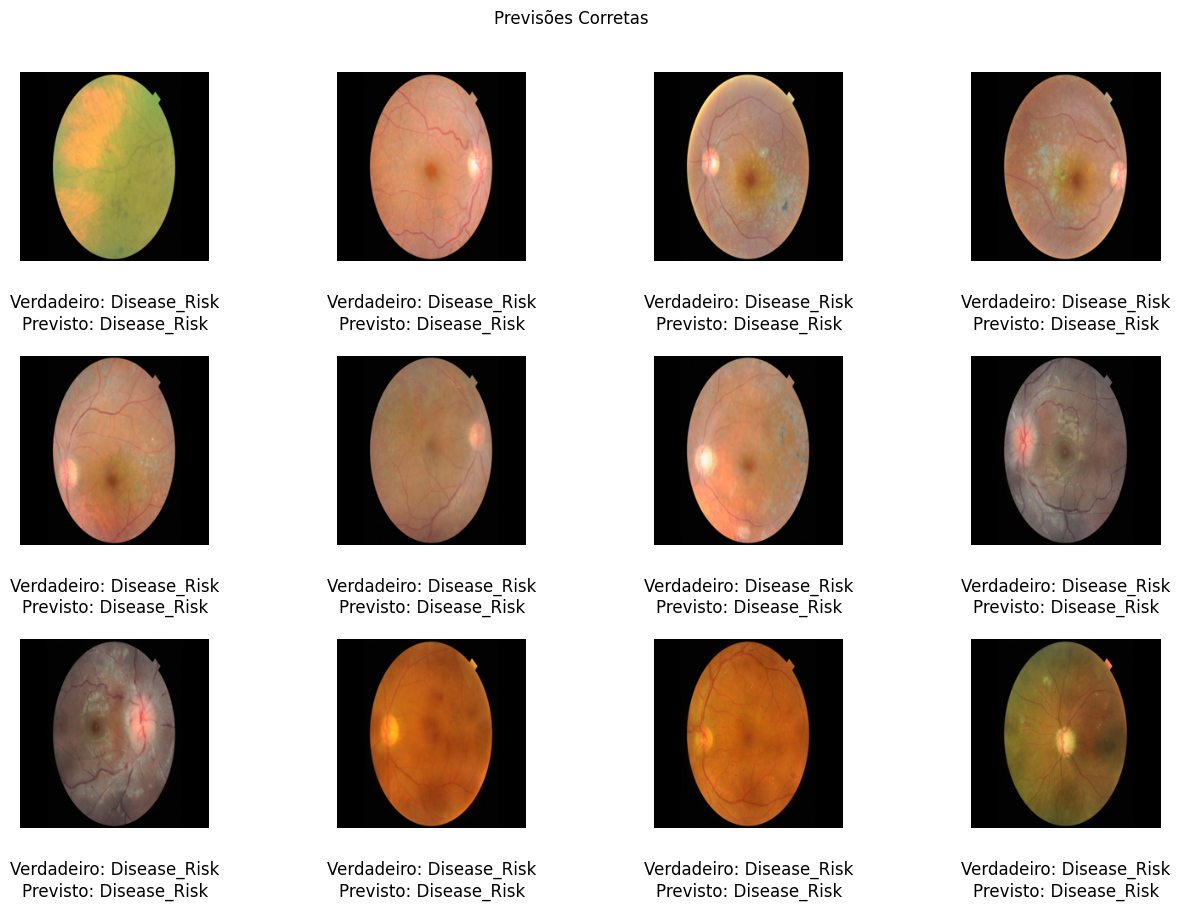

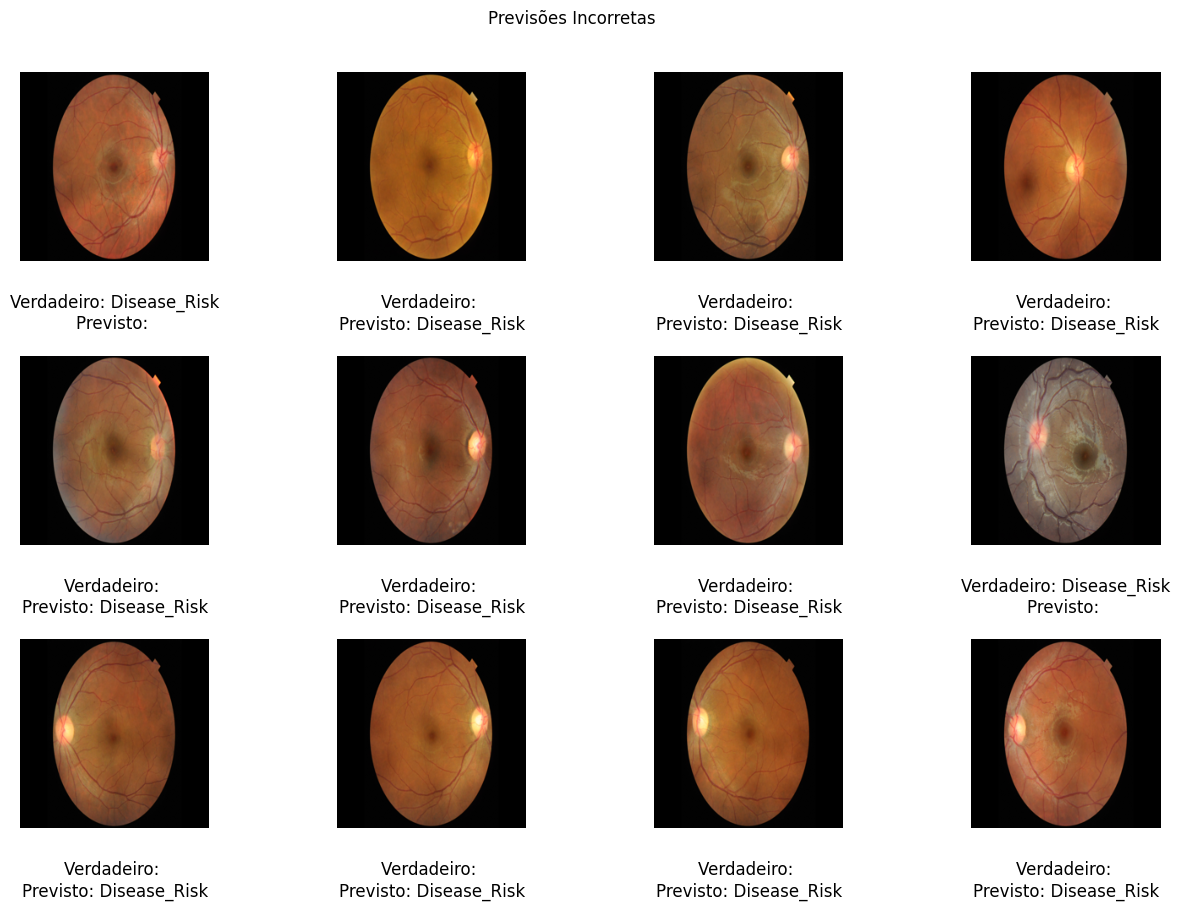

In [77]:
# Índices das previsões corretas e incorretas
correct_indices = np.where(np.all(y_pred_labels == y_true_val, axis=1))[0]
incorrect_indices = np.where(np.any(y_pred_labels != y_true_val, axis=1))[0]

print(f"Número de previsões corretas: {len(correct_indices)}")
print(f"Número de previsões incorretas: {len(incorrect_indices)}")

# Função auxiliar para exibir imagens
def plot_images_in_batches(indices, title, batch_size, images_per_row):
    num_images = len(indices)
    batch_size = min(batch_size, num_images) 

    batch_indices = indices[:batch_size]
    rows = (len(batch_indices) // images_per_row) + (len(batch_indices) % images_per_row > 0)

    plt.figure(figsize=(15, rows * 3))
    for i, idx in enumerate(batch_indices):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(X_val[idx].reshape((224,224,3)))

        # Rótulos verdadeiros e previstos para a imagem atual
        true_labels = [label_names[j] for j in range(len(label_names)) if y_true_val[idx, j] == 1]
        predicted_labels = [label_names[j] for j in range(len(label_names)) if y_pred_labels[idx, j] == 1]

        plt.title(f"Verdadeiro: {', '.join(true_labels)}\nPrevisto: {', '.join(predicted_labels)}", y=-0.4)
        plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)  # Ajusta o espaço entre as imagens
    plt.suptitle(title, y=1.02)
    plt.show()

# Exibir previsões corretas e incorretas
plot_images_in_batches(correct_indices, "Previsões Corretas", batch_size=12, images_per_row=4)
plot_images_in_batches(incorrect_indices, "Previsões Incorretas", batch_size=12, images_per_row=4)
